In [1]:
from data_detection import *

In [10]:
# define a function that generate a np array of random values from a normale distribution
def generate_random_data(n):
    return np.random.normal(0, 1, n)

def generate_random_data2():
    return np.random.normal(0, 1)

In [ ]:
for i in range(10000000):
    generate_random_data2()

In [11]:
generate_random_data(10000000)

array([-0.0316292 ,  1.26365543,  0.62325139, ...,  1.30778989,
       -1.73232253,  1.12858879])

In [4]:
np.zeros((10,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [184]:
from statsmodels.datasets import co2
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
data = co2.load().data
data = data.resample('ME').mean().ffill()


526

In [172]:
df = pd.DataFrame(data_points)
df

,0
0,-1.987273
1,1.610530
2,-1.160470
3,1.262787
4,4.086257
...,...
521,146.481783
522,15.523681
523,16.222000
524,14.887525


In [173]:
data

,co2
1958-03-31,316.100000
1958-04-30,317.200000
1958-05-31,317.433333
1958-06-30,317.433333
1958-07-31,315.625000
...,...
2001-08-31,369.425000
2001-09-30,367.880000
2001-10-31,368.050000
2001-11-30,369.375000


In [186]:
pd.DataFrame(data_points).index

RangeIndex(start=0, stop=526, step=1)

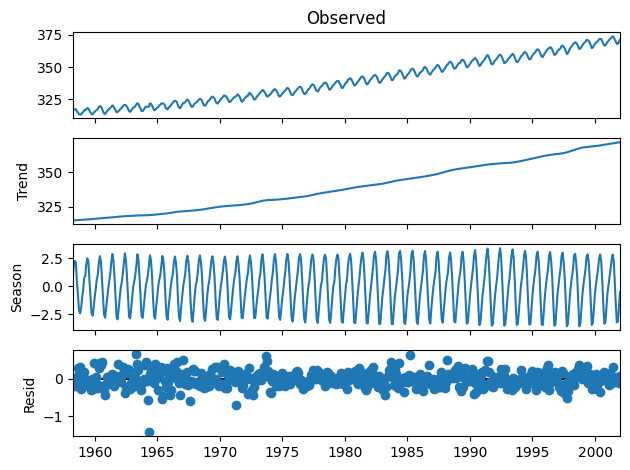

In [168]:

from statsmodels.tsa.seasonal import STL
res = STL(data).fit()
res.plot()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from statsmodels.tsa.seasonal import STL
import logging
from data_stream import *

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

# Define the trend, seasonality, and noise functions
def trend(t):
    return 0.1 * t  # Linear trend

def seasonality(t):
    return 50 * np.sin(2 * np.pi * t / 200)  # Seasonal cycle

def noise(size):
    return np.random.normal(0, 2, size)  # Random noise with mean 0 and standard deviation 2

# Function to generate a data point with trend, seasonality, and noise
def generate_data_points(num):
    t = np.arange(num)
    return trend(t) + seasonality(t) + noise(num)

# Function to generate a data points with p = 0.1 anomalies
def generate_data_point_with_anomalies(num,p):
    data_points = generate_data_points(num)
    # create the anomalies 
    anomalies_num = int(p*num)
    anomalies_values = np.random.normal(50, 1000, anomalies_num)
    anomalies_indices = np.random.permutation(num)[:anomalies_num]
    data_points[anomalies_indices] = anomalies_values
    
    
    return data_points, anomalies_indices


def stl_zscore_anomaly_detection(data_stream, window_size=1000, z_threshold=3):
    """
    Detects anomalies in a data stream using STL decomposition and Z-Score.

    Parameters:
    - data_stream: list or iterable of incoming data points (float values).
    - window_size: int, the number of most recent data points to use for each STL decomposition.
    - seasonal_period: int, estimated period for seasonality (e.g., 12 for monthly data if the data is daily).
    - z_threshold: float, Z-Score threshold for flagging anomalies.

    Returns:
    - anomalies: list of tuples (index, value) where anomalies were detected.
    """
    # Store data points and anomalies
    data_window = []
    anomalies = []

    for index, data_point in enumerate(data_stream):
        # Append the new data point to the sliding window
        data_window.append(data_point)
        
        # Maintain only the latest `window_size` points in the sliding window
        if len(data_window) > window_size:
            data_window.pop(0)
        
        # Proceed only when the sliding window is full
        if len(data_window) == window_size:
            # Perform STL decomposition
            try:
                stl = STL(pd.Series(data_window), seasonal=seasonal_period)
                result = stl.fit()
                residual = result.resid

                # Calculate Z-Score for the residual
                mean_resid = np.mean(residual)
                std_resid = np.std(residual)
                z_scores = (residual - mean_resid) / std_resid

                # Check the most recent data point's Z-Score for anomaly
                if abs(z_scores[-1]) > z_threshold:
                    logging.info(f"Anomaly detected at index {index}: {data_point} (Z-Score: {z_scores[-1]:.2f})")
                    anomalies.append((index, data_point))
                    
            except Exception as e:
                logging.error(f"Error in STL decomposition or Z-Score calculation: {e}")

        # Log data generation at each step
        logging.info(f"Data point {index}: {data_point}")

    return anomalies
    # prepare data to pass it to the STL (change it to dataFrame)
    data_stream = pd.DataFrame(data_stream)
    # change the index to be the time
    data_stream.index = pd.date_range(start='1/1/2020', periods=len(data_stream), freq='ms')
    
    # Initialize the STL decomposition
    stl = STL(data_stream)
    # Perform the decomposition
    stl = stl.fit()
    # Extract the residuals
    residuals = stl.resid
    # Initialize the anomaly indices
    anomaly_indices = []
    # Initialize the anomaly scores
    anomaly_scores = []
    # Initialize the anomaly count
    anomaly_count = 0
    # Initialize the window
    window = []
    # Iterate over the residuals
    for i, residual in enumerate(residuals):
        # Append the residual to the window
        window.append(residual)
        # If the window size is reached
        if len(window) == window_size:
            # Compute the mean and standard deviation of the window
            window_mean = np.mean(window)
            window_std = np.std(window)
            # Compute the z-score of the last residual
            z_score = (residual - window_mean) / window_std
            # If the z-score is above the threshold
            if abs(z_score) > z_threshold:
                # Append the anomaly index
                anomaly_indices.append(i)
                # Append the anomaly score
                anomaly_scores.append(z_score)
                # Increment the anomaly count
                anomaly_count += 1
            # Remove the first residual from the window
            window.pop(0)
    return anomaly_indices, anomaly_scores, anomaly_count
    



In [440]:
data_points, anomalies_indecies = generate_data_point_with_anomalies(10000,0.01)

In [441]:
predicted_anomalies = stl_zscore_anomaly_detection(data_points, window_size=500, z_threshold=3)

In [442]:
predicted_anomalies[2]

159

In [443]:
count = 0
for i in predicted_anomalies[0]:
    if i in anomalies_indecies:
        count += 1
count,(predicted_anomalies[2]-count)/10000,count/predicted_anomalies[2]

(69, 0.009, 0.4339622641509434)

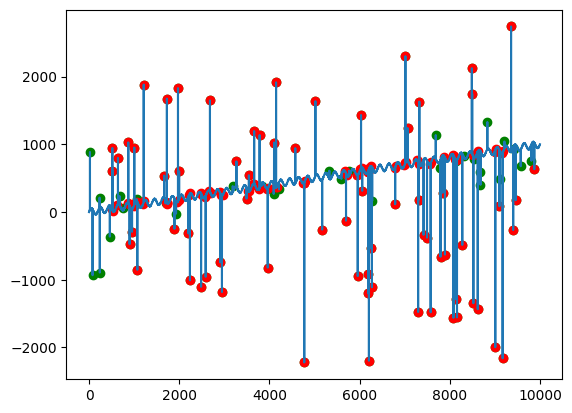

In [444]:
# plot the data points with the anomalies and change color of the anomalies
plt.plot(data_points)
plt.scatter(anomalies_indecies, [data_points[i] for i in anomalies_indecies], color='green')
plt.scatter(predicted_anomalies[0], [data_points[i] for i in predicted_anomalies[0]], color='red')
plt.show()
